## Guide: SynthEvo and symbolic gradient descent

This notebook present how to use SynthEvo's symbolic gradient descent capabilities to optimize a CRN model.

We will consider the case of Near-Perfect adaptation, using the loss function presented in the our CDC paper.

First of all we need to import SynthEvo

In [4]:
using SynthEvo

nothing

Precompiling SynthEvo
  ✓ SynthEvo
  1 dependency successfully precompiled in 28 seconds. 374 already precompiled.


Then we define the problem we want to address. In this specific case we consider 

* a three node fully connected CRN (as defined in the reference manuscript)
* the unperturbed system has input fixed to 1
* the unperturbed system is simulated up to $t_0=10$
* the perturbed system is simulated up to $t_1=20$

In [5]:
C = SynthEvo.make_FullyConnectedNonExplosive_CRN(3)

input = 1
t0 = 10.
t1 = 20.

base_problem = make_base_problem_for_FCNE_CRN(C, C.ext_ode, t0, input)

nothing

We then define a list of possible perturbations of the system, and we will optimize the system's parameter to minimize a loss function.

In detail, the considered loss function will have 4 terms:

* an adaptation term (computed between the empirical steady states)
* a sensitivity term to avoid non reactive systems
* a soft-constraint to avoid unstable systems
* a regularization term to avoid overly complex CRNs and prune reactions

In [6]:
perturbation_list = vcat([i+1 for i in 1:12], [0.1,0.5, 0.8])

loss1 = SynthEvo.adaptation_loss(C, 2, 3, 10., 20.)
loss2 = SynthEvo.sensitivity_loss(C, 2, 3, 0.25, 10., 10.5)
loss3 = SynthEvo.steady_state_loss(C, 2, 10., 20., 6, 16.)
loss4 = SynthEvo.regularization_loss(C, 1)
l = SynthEvo.weighted_loss([loss1, loss2, loss3, loss4], [10,10,100,0.1])

nothing

Now we need to define the details of the optimization process. 
In SynthEvo this requires the definition of two structs like the following:

In [7]:
gd_options = (
    n_iter = 500,
    verbose = true,
    use_random_perturbation = false,
    use_pruning_heuristic = false,
    clip_value = nothing,
    use_gradient_normalization = false,
    use_gradient_noise = false,
    fraction_gradient_noise = 0.1,
    alpha = 0.1,
    use_adam = false,
    ADAM_beta1 = 0.9,
    ADAM_beta2 = 0.9,
    use_adagrad = true
)


gd_perturbation_options = (
    t0 = t0,
    t1 = t1,
    loss_fun = l,
    input = input,
    perturbation_list = vcat([i+1 for i in 1:12], [0.1, 0.3, 0.5, 0.8])
)

nothing

Now we are ready to run the optimization process.
This should take around a minute to complete.

In [8]:
# let's sample the initial parameters at random
p0 = [rand() for i in 1:C.number_of_parameters]
results = SynthEvo.symbolic_gradient_descent(p0, C, gd_options, gd_perturbation_options, nothing)
nothing

we can use `results` as a checkpoint to continue the optimization process at a later time.

In [9]:
results = SynthEvo.symbolic_gradient_descent(results.parameters, C, gd_options, gd_perturbation_options, results)
nothing

Finally, `SynthEvo` provides methods to visualize the optimization results.

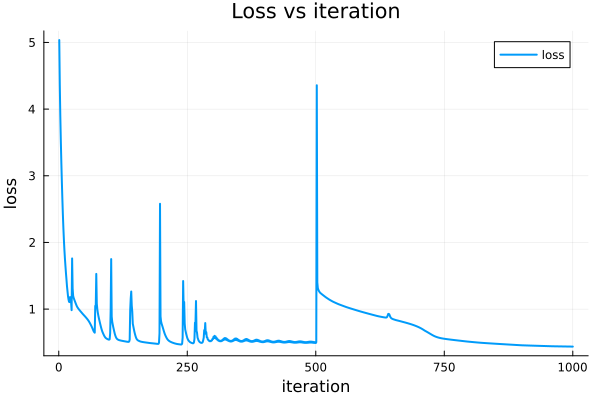

In [10]:
symGD_plot_loss(results)

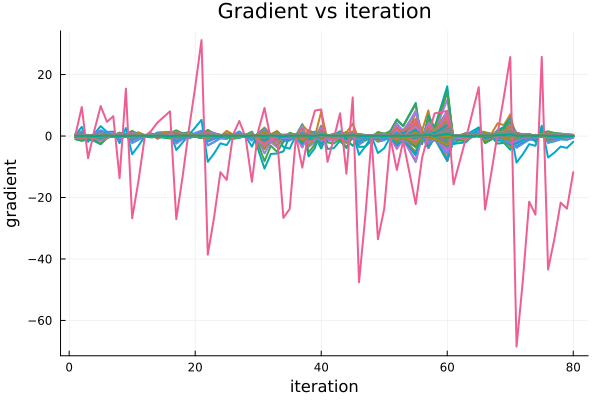

In [11]:
symGD_plot_gradient(results)

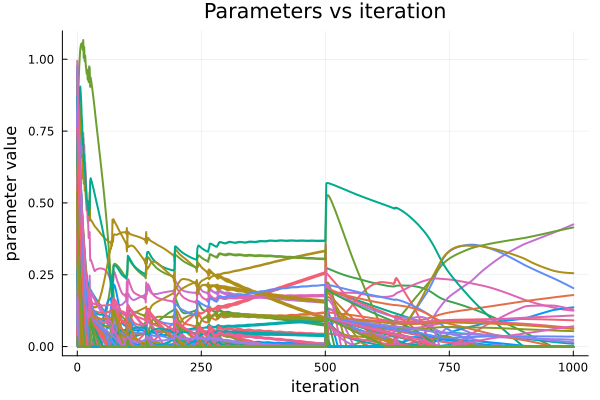

In [12]:
symGD_plot_parameters(results)

### Considering a specific solution

We can also explore the behavior of a specific solution, by picking a paraneter set from the
`parameter_tape` of the `results` struct. In this cas we pick the best solution found so far, so the one that minimizes the observed loss.

In [13]:
choosen_parameter_set = results.parameter_tape[argmin(results.loss_tape)]

nothing

We can check the behavior of the system by simulating it using the `quick_trajectory_plot` method.
In black we can see the trajectories of just the target species as the system undergoes different perturbations.

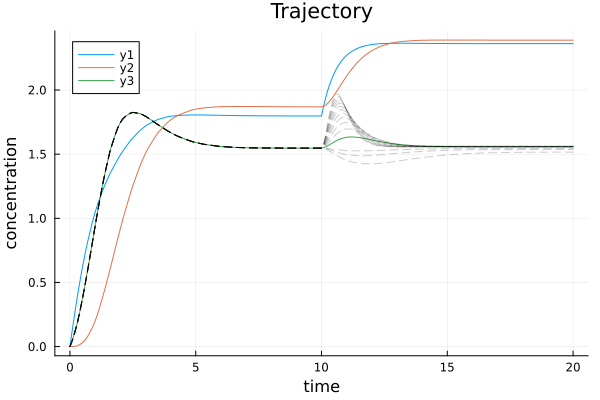

In [14]:
SynthEvo.quick_trajectory_plot(C, results.parameter_tape[argmin(results.loss_tape)], 1., perturbation_list, 10., 20., 3)

We can also take a look at the sensitivities

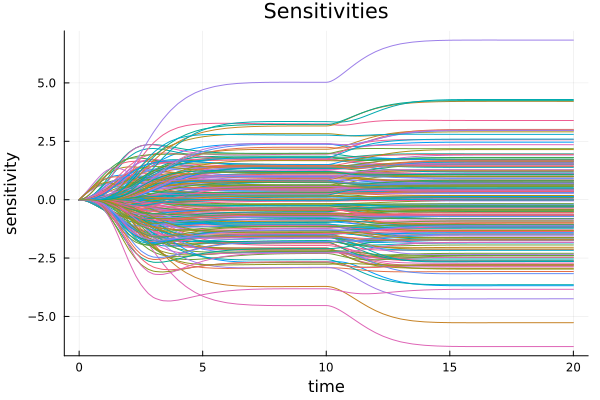

In [34]:
quick_sensitivity_plot(C,choosen_parameter_set, 1., 2., 10., 20., 3.)

Finally, in the scenario were we consider Near-Perfect adaptation, we can also compute the homeostatic coefficient of the computed network:

In [28]:
hc = compute_homeostatic_coefficient(C, choosen_parameter_set, 1, 2.5, 10., 20.)
println("A_22_A_31 - A_21_A_32 = ", hc.A_22_A_31, " - ", hc.A_21_A_32, " = ", hc.coefficient)

A_22_A_31 - A_21_A_32 = -1.2487620731855213 - -1.2260964045698715 = -0.022665668615649892


and use the results to check if the system is of the NFB or IFF type.

In [29]:
if abs(hc.A_22_A_31) + abs(hc.A_21_A_32) < 0.1
    println("The system is NFB-like")
else
    println("The system is IFF-like")
end

The system is IFF-like


We can also check which are the reactions that are most important for the CRN's behavior.

In [30]:
f_CRN = sortAndFilterReactions(C, choosen_parameter_set, 0.05)
f_CRN.reaction_selection

14-element Vector{Tuple{Float64, Catalyst.Reaction{Any, Int64}}}:
 (0.42456748225450114, k[4], ∅ --> (x(t))[1] + (x(t))[3])
 (0.4142543645129157, k[16], (x(t))[1] --> 2*(x(t))[3])
 (0.25559746549820866, k[53], 2*(x(t))[1] --> 2*(x(t))[2])
 (0.2042854772676426, k[13], (x(t))[1] --> (x(t))[1] + (x(t))[3])
 (0.17924373896891957, k[34], (x(t))[2] + (x(t))[3] --> ∅)
 (0.1364814597665094, k[33], 2*(x(t))[2] --> ∅)
 (0.12911141264535597, k[63], (x(t))[1] + (x(t))[3] --> 2*(x(t))[2])
 (0.12532937347322692, k[31], (x(t))[1] + (x(t))[2] --> ∅)
 (0.10821763674172179, k[47], (x(t))[2] + (x(t))[3] --> (x(t))[2])
 (0.09142293440111926, k[46], (x(t))[2] + (x(t))[3] --> (x(t))[1])
 (0.07037211809135836, k[79], 2*(x(t))[3] --> 2*(x(t))[2])
 (0.06465373764302554, k[71], (x(t))[2] + (x(t))[3] --> 2*(x(t))[1])
 (0.06176836244751555, k[72], (x(t))[2] + (x(t))[3] --> (x(t))[1] + (x(t))[2])
 (0.05404016576696009, k[74], (x(t))[2] + (x(t))[3] --> 2*(x(t))[2])

and we can check if the system restricted to these reaction is still able to perform Near-Perfect adaptation

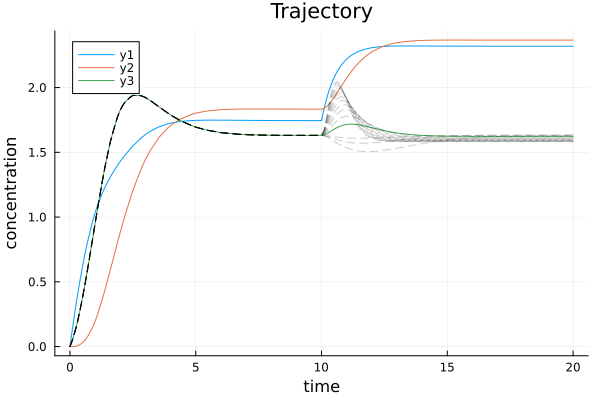

In [31]:
SynthEvo.quick_trajectory_plot(C, f_CRN.filtered_parameters, 1., perturbation_list, 10., 20., 3)